<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN (Generative Adversarial Networks)

## 1. Load dataset

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_2000.zip -d ./data2000

Retrieving folder contents
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6
To: /content/dataset/data_500.zip
100% 567k/567k [00:00<00:00, 75.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY
To: /content/dataset/data_1000.zip
100% 1.20M/1.20M [00:00<00:00, 28.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj
To: /content/dataset/data_2000.zip
100% 2.27M/2.27M [00:00<00:00, 80.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF
From (redirected): https://drive.

## 2. Import python libraries and define util functions

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torch.utils.data.dataset import random_split
from torchvision.utils import save_image
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

In [ ]:
set_seed(0)

## 3. Check dataset

In [ ]:
path = './data2000/23.119.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Convert images into trainable data

In [ ]:
# image size = 56 x 56, 2000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './data2000/'

# loop through the files, read each image, and normalize it (-1 to 1)
def get_data():
    files = os.listdir(src)  # get the list of files in the source directory
    X = []  # initialize empty lists for storing images

    for file in files:
        X.append((img_read(src,file)-127.5)/127.5)  # normalize the data between -1 and 1

    # split the data into 80% training set and 20% test set (test set can be considered as validation)
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=1,shuffle=True)

    # expand dimension to (batch_size, 1, height, width) in PyTorch
    X_train = np.expand_dims(X_train, axis=1)  # axis=1 for channel in PyTorch
    X_test = np.expand_dims(X_test, axis=1)  # same for test set

    return X_train, X_test

X_train, X_test = get_data()  # load data set (no y label needed as we only need images) / unsupervised learning

print("X_train.shape = {}".format(X_train.shape))
print("X_test.shape = {}".format(X_test.shape))

X_train.shape = (1600, 1, 56, 56)
X_test.shape = (400, 1, 56, 56)


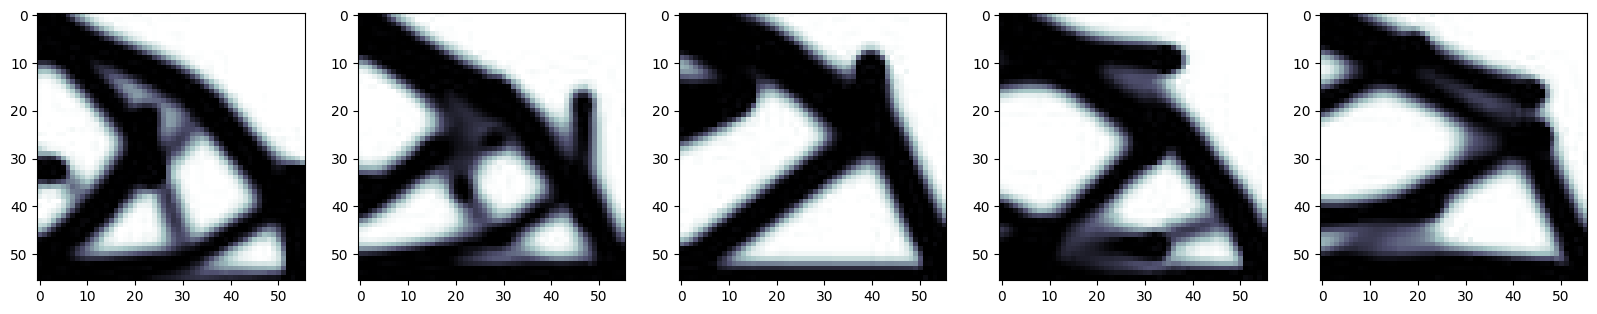

In [ ]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X_train[i, 0, :, :],cmap = plt.cm.bone)
plt.show()

## 5. Set to model architecture

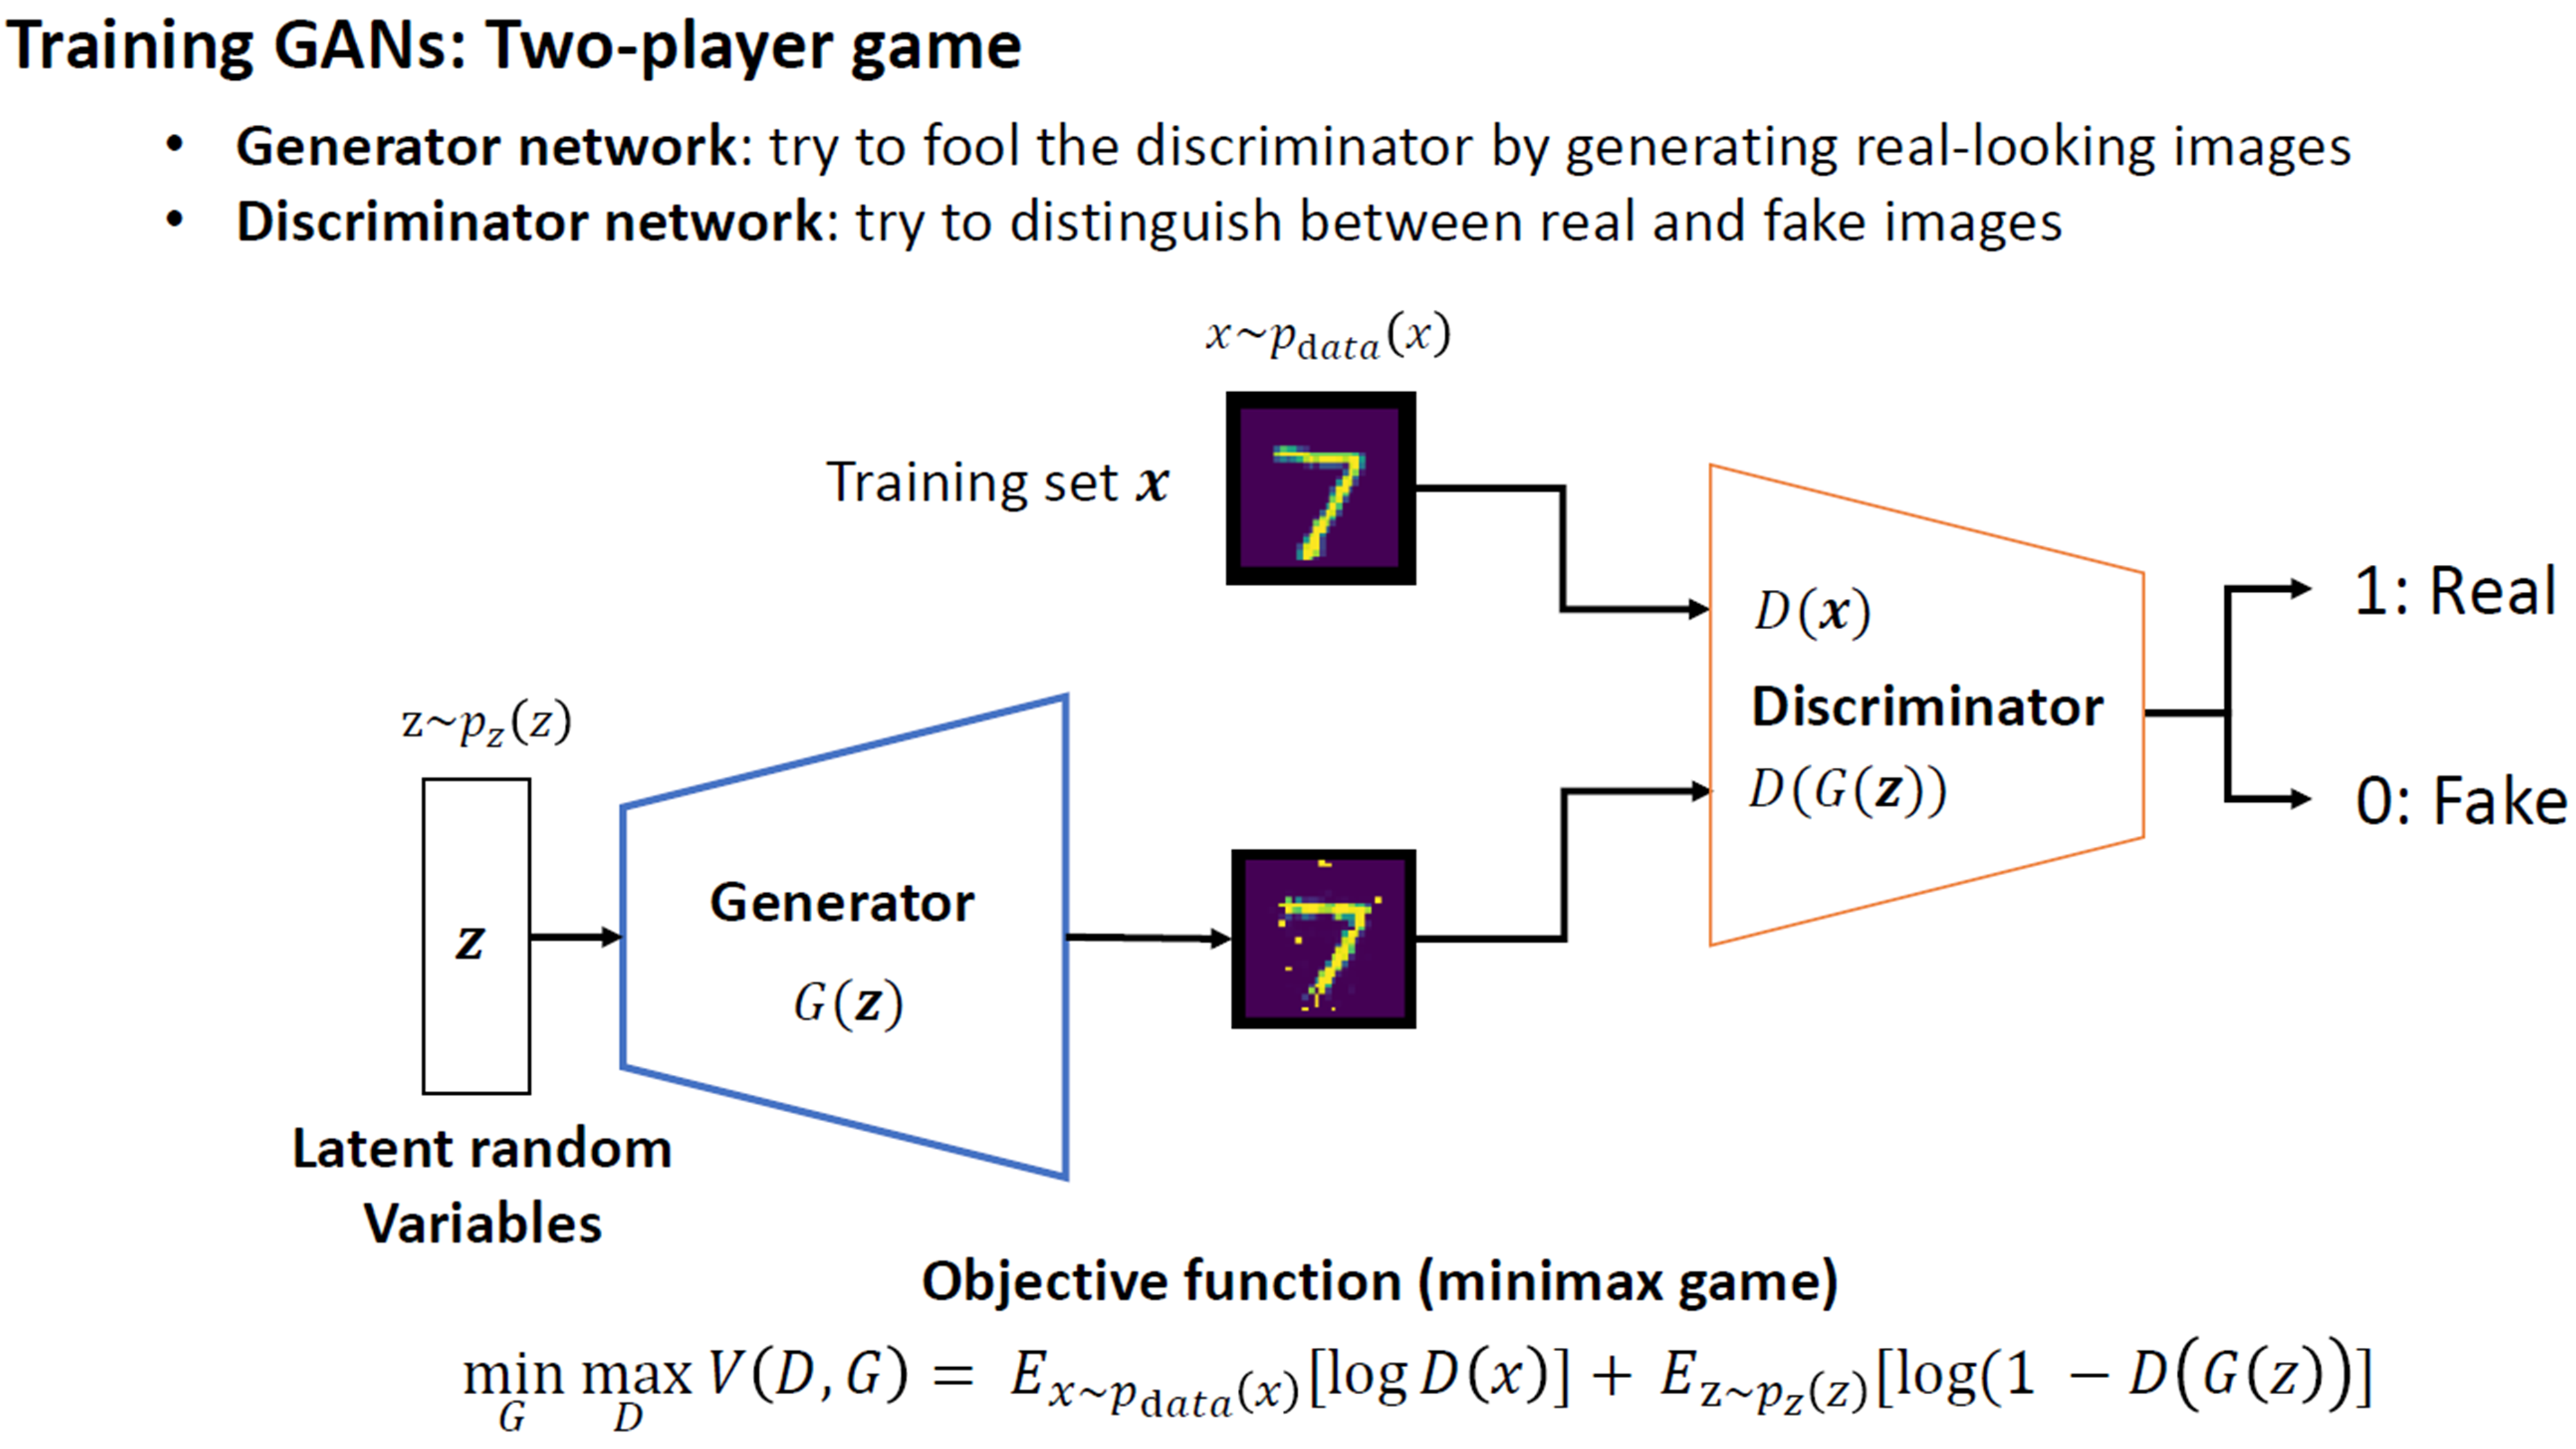

In [ ]:
# ---------------------
#  Generator Network (input : noise >> output : image)
# ---------------------

class Generator(nn.Module):  # generate real-looking images
    def __init__(self):
        super(Generator, self).__init__()

        self.generator = nn.Sequential(
            nn.Linear(noise_size, hidden_size1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size3, img_size),
            nn.Tanh()
        )

    def forward(self, x):
        gen = self.generator(x)

        return gen

# ---------------------
#  Discriminator Network (input : image >> output : [1 / Real] or [0 / Fake])
# ---------------------

class Discriminator(nn.Module):  # distinguish between real and fake images
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(img_size, hidden_size3),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_size3, hidden_size2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_size2, hidden_size1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_size1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        dis = self.discriminator(x)

        return dis

## 6. Set model hyperparameters

In [ ]:
# model architecture parameters
hidden_size1 = 64
hidden_size2 = 256
hidden_size3 = 784
noise_size = 100

# training parameters
learning_rate = 0.0002
batch_size = 32
num_epoch = 200

# fixed values
img_size = 56 * 56              # image size
num_channel = 1                 # grayscale images
img_shape = (num_channel,56,56) # grayscale images

## 7. Train model

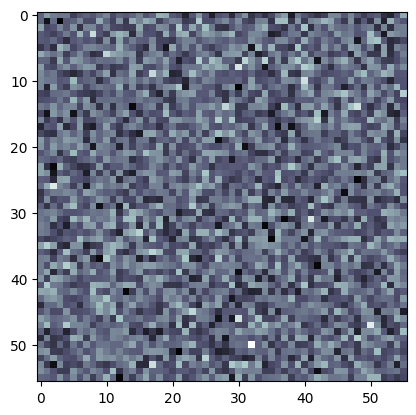

In [ ]:
# define networks and set to device (GPU)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# convert data to PyTorch tensors
train_images = torch.tensor(X_train, dtype=torch.float32).to(device)
test_images = torch.tensor(X_test, dtype=torch.float32).to(device)

# create DataLoader for training and validation data
train_dataset = TensorDataset(train_images)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# set to loss function & optimizer
criterion = nn.BCELoss() # binary cross entropy loss for binary classification
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# check generated fake bracket image
generated_image = generator(torch.randn([1, 100]).to(device)).cpu().detach()
plt.imshow(torch.reshape(generated_image, (56,56)), cmap=plt.cm.bone)

In [ ]:
"""
Training part
"""
for epoch in range(num_epoch):

    for i, (images) in enumerate(train_loader):

        # make ground truth (labels) -> [1 / Real] & [0 / Fake]
        real_label = torch.full((batch_size, 1), 1, dtype=torch.float32).to(device)
        fake_label = torch.full((batch_size, 1), 0, dtype=torch.float32).to(device)

        # reshape real images --> flatten to (batch_size, 56*56)
        real_images = images[0].reshape(batch_size, -1)  # flatten image to (batch_size, 56*56)

        # +---------------------+
        # |   train Generator   |
        # +---------------------+

        # initialize gradient -> initialize generator model gradient to 0
        g_optimizer.zero_grad()

        # make fake images with generator & noise vector 'z'
        z = torch.randn(batch_size, noise_size).to(device)
        fake_images = generator(z)

        # compare result of discriminator with fake images & real labels
        # if generator deceives discriminator, g_loss will decrease
        g_loss = criterion(discriminator(fake_images), real_label)

        # train generator with backpropagation
        g_loss.backward()
        g_optimizer.step()

        # +---------------------+
        # | train Discriminator |
        # +---------------------+

        # initialize gradient -> initialize discriminator model gradient to 0
        d_optimizer.zero_grad()

        # calculate fake & real loss with generated images above & real images
        fake_loss = criterion(discriminator(fake_images.detach()), fake_label)
        real_loss = criterion(discriminator(real_images), real_label)
        d_loss = (fake_loss + real_loss)/2

        # train discriminator with backpropagation
        d_loss.backward()
        d_optimizer.step()

    print("Epoch [ {}/{} ]  d_loss : {:.5f}  g_loss : {:.5f}".format(epoch+1, num_epoch, d_loss.item(), g_loss.item()))

Epoch [ 1/200 ]  d_loss : 0.08039  g_loss : 2.47777
Epoch [ 2/200 ]  d_loss : 0.09730  g_loss : 1.94058
Epoch [ 3/200 ]  d_loss : 0.07878  g_loss : 2.42679
Epoch [ 4/200 ]  d_loss : 0.06931  g_loss : 5.09290
Epoch [ 5/200 ]  d_loss : 0.94403  g_loss : 0.21891
Epoch [ 6/200 ]  d_loss : 0.10490  g_loss : 2.00166
Epoch [ 7/200 ]  d_loss : 0.41201  g_loss : 1.89323
Epoch [ 8/200 ]  d_loss : 0.03967  g_loss : 3.82031
Epoch [ 9/200 ]  d_loss : 0.07369  g_loss : 3.35194
Epoch [ 10/200 ]  d_loss : 0.02719  g_loss : 3.54596
Epoch [ 11/200 ]  d_loss : 0.03781  g_loss : 3.75771
Epoch [ 12/200 ]  d_loss : 0.05177  g_loss : 2.87756
Epoch [ 13/200 ]  d_loss : 0.22702  g_loss : 1.45114
Epoch [ 14/200 ]  d_loss : 0.07924  g_loss : 4.05427
Epoch [ 15/200 ]  d_loss : 0.21538  g_loss : 4.58409
Epoch [ 16/200 ]  d_loss : 0.00700  g_loss : 5.29651
Epoch [ 17/200 ]  d_loss : 0.32003  g_loss : 5.28251
Epoch [ 18/200 ]  d_loss : 0.01230  g_loss : 4.45180
Epoch [ 19/200 ]  d_loss : 0.15959  g_loss : 2.72912
Ep

## 8. Load & Evaluate model

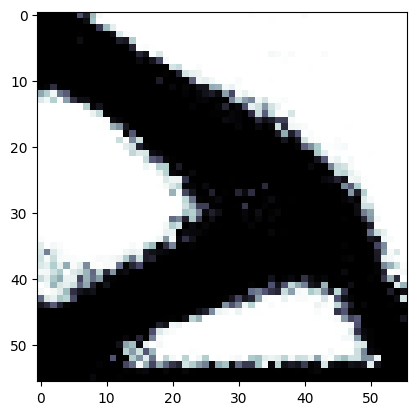

In [ ]:
# check generated fake bracket image
generated_image = generator(torch.randn([1, 100]).to(device)).cpu().detach()
plt.imshow(torch.reshape(generated_image, (56,56)), cmap=plt.cm.bone)